<h2>Implementación de SRGAN para la generación de imágenes en Super Resolución</h2>

Se importan las librerías necesarias para la ejecución del Notebook.

In [1]:
import os
import time
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.metrics import Mean
from PIL import Image
import matplotlib.pyplot as plt

from Utils.metrics import rmse_metric
from Utils.callbacks import SaveCustomCheckpoint
from Dataset.dataset_config import DatasetConfig
from Dataset.dataset_loader import create_training_and_validation_datasets
from Dataset.dataset_mappings import random_crop, random_flip, random_rotate, random_lr_jpeg_noise
from Modelos.generator import build_generator
from Modelos.discriminator import build_discriminator

2023-06-04 20:44:35.843761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 20:44:35.911688: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-04 20:44:36.200971: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libcublas.so.12: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/pablodonav/miniconda3/envs/tf/lib/
2023-06-04 20:44:36.200985: W tensorflow/compiler

<h3>Preparación del dataset:</h3>

In [2]:
""" Nombre del dataset a utilizar ("bicubic_x4" o "chest_x-ray") """
dataset_name = "chest_x-ray"

""" Ubicación de la carpeta de los datasets. """
dataset_folder = os.path.abspath(os.path.join(os.getcwd(), "Dataset", dataset_name))

""" Ubicación de la carpeta de los resultados de entrenamiento. """
training_results_folder = f"training_results/srgan_{dataset_name}"

""" Se definen los parámetros del dataset """
dataset_parameters = DatasetConfig(dataset_name, save_data_directory=dataset_folder)

Se definen algunos hiperparámetros.

In [3]:
""" Se define el tamaño de los recortes o crops. """
crop_size = 48

""" Tamaño de batch.
      Número de imágenes LR que son procesadas simultáneamente durante el entrenamiento.
      Cuanto mayor sea, más rapido el entrenamiento, pero más memoria y calculo necesitará. """
batch_size = 16

""" Tasa de aprendizaje.
      Porcentaje de cambio con el que se actualizan los pesos en cada iteración.
      Controla la velocidad a la que la red neuronal converge hacia la solución óptima durante el entrenamiento.
      Una tasa de aprendizaje alta puede llevar a oscilaciones o divergencia durante el entrenamiento,
      mientras que una tasa de aprendizaje demasiado baja puede hacer que el modelo tarde demasiado en converger hacia la solución óptima. """
learning_rate=1e-4

""" Se definen las iteraciones del entrenamiento del generador. """
gen_training_steps = 1_000
gen_steps_per_epoch = 100
gen_training_epochs = gen_training_steps / gen_steps_per_epoch

""" Se definen las iteraciones del entrenamiento del modelo combinado. """
steps = 200_000

""" Se definen el número de bits de las imágenes de entrada """
num_bits_img = 8

Se definen las funciones de mapeado que se van a aplicar sobre el dataset con el fin de realizar un pre-procesamiento y aumento de datos.

In [4]:
train_mapping = [
    lambda lr, hr: random_crop(lr, hr, hr_crop_size=crop_size, scale=dataset_parameters.scale),
    random_flip,
    random_rotate]

Se crea el dataset de entrenamiento y validación.

In [5]:
train_dataset, valid_dataset = create_training_and_validation_datasets(dataset_parameters, batch_size, train_mapping)

""" Se toman únicamente las primeras 10 imágenes del dataset de validación. """
valid_dataset_subset = valid_dataset.take(10)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-06-04 20:44:36.934746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 20:44:36.937677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 20:44:36.937744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 20:44:36.938120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

Se entrena la red Generadora

<h2>MODELO COMBINADO</h2>

In [6]:
""" Se obtiene el generador previamente entrenado y se cargan sus pesos y configuraciones. """
generator = build_generator(scale=dataset_parameters.scale, num_filters=64, num_residual_blocks=16)
generator.summary()
#generator.load_weights(weights_file)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda (Lambda)                (None, None, None,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   5248        ['lambda[0][0]']                 
                                64)                                                           

In [7]:
""" Se obtiene el discriminador """
discriminator = build_discriminator(hr_crop_size=crop_size)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 lambda_4 (Lambda)           (None, 48, 48, 1)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 batch_normalization_33 (Bat  (None, 24, 24, 64)       256 

Se define la red neuronal VGG19.

In [8]:
""" VGG19 se utiliza como un extractor de características para calcular la pérdida de contenido durante el entrenamiento del 
      modelo, ya que comparar los píxeles entre las dos imágenes puede no ser suficiente. """
""" La capa 5-4 es una de las últimas capas convolucionales de VGG19 y se utiliza comúnmente como extractor de características en aplicaciones 
      de procesamiento de imágenes. Al procesar una imagen a través de VGG19, la capa 5-4 representa características de alto nivel de la imágen,
      como patrones y formas complejas. """
layer_5_4 = 20
img_input = keras.layers.Input(shape=(None, None, 1))
img_conc = keras.layers.Concatenate()([img_input, img_input, img_input]) 
vgg = VGG19(weights='imagenet', input_tensor=img_conc, include_top=False)
perceptual_model = Model(vgg.input, vgg.layers[layer_5_4].output)

In [9]:
""" Entropía cruzada binaria -> Función de pérdida que determina qué tanto por ciento se parece la imagen generada a la imagen real. """
binary_cross_entropy = BinaryCrossentropy()

""" Función de pérdida para medir el error cuadrático medio de las predicciones del modelo en relación con los valores verdaderos. """
mean_squared_error = MeanSquaredError()

In [10]:
""" Se definen los valores que va a tomar el learning rate, indicando que a partir de la iteración 100.000, 
    el learning rate va a disminuir de 1e-4 a 1e-5. """
learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])

In [11]:
""" Se definen las funciones de optimización del generador y discriminador.
        En este caso, se utilizan las funciones Adam en ambos casos. """
generator_optimizer = Adam(learning_rate=learning_rate)
discriminator_optimizer = Adam(learning_rate=learning_rate)

Se definen los checkpoints que van a ir salvando el entrenamiento del modelo (generador y discriminador).

In [12]:
srgan_checkpoint_dir=f'checkpoints/srgan_{dataset_name}'

srgan_checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                       generator_optimizer=generator_optimizer,
                                       discriminator_optimizer=discriminator_optimizer,
                                       generator=generator,
                                       discriminator=discriminator)

srgan_checkpoint_manager = tf.train.CheckpointManager(checkpoint=srgan_checkpoint,
                                                directory=srgan_checkpoint_dir,
                                                max_to_keep=3)

In [13]:
if srgan_checkpoint_manager.latest_checkpoint:
    srgan_checkpoint.restore(srgan_checkpoint_manager.latest_checkpoint)
    print(f'Modelo restaurado con checkpoint en el paso {srgan_checkpoint.step.numpy()}.')

In [14]:
@tf.function
def train_step(lr, hr):
    """ Se calculan los gradientes de la función de perdida del generador y del discriminador. """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)
        
        sr = srgan_checkpoint.generator(lr, training=True)

        hr_output = srgan_checkpoint.discriminator(hr, training=True)
        sr_output = srgan_checkpoint.discriminator(sr, training=True)

        mse = calculate_content_loss(hr, sr)
        gen_loss = calculate_generator_loss(sr_output)
        perc_loss = mse + 0.001 * gen_loss
        hr_loss, sr_loss = calculate_discriminator_loss(hr_output, sr_output)
        disc_loss = hr_loss + sr_loss

    gradients_of_generator = gen_tape.gradient(perc_loss, srgan_checkpoint.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, srgan_checkpoint.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, srgan_checkpoint.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, srgan_checkpoint.discriminator.trainable_variables))

    return perc_loss, hr_loss, sr_loss, disc_loss

@tf.function
def calculate_content_loss(hr, sr):
    sr_features = perceptual_model(sr)
    hr_features = perceptual_model(hr)
    return mean_squared_error(hr_features, sr_features)

def calculate_generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def calculate_discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss, sr_loss

In [15]:
gen_loss_array = np.array([])
disc_loss_array = np.array([])
hr_loss_array = np.array([])
sr_loss_array = np.array([])
rmse_error_array = np.array([])
time_array = np.array([])

start_time = time.time()
step = srgan_checkpoint.step.numpy()

""" Se crea el directorio de resultados de entrenamiento. """
os.makedirs(training_results_folder, exist_ok=True)

for lr, hr in train_dataset.take(steps - step):

    srgan_checkpoint.step.assign_add(1)
    step = srgan_checkpoint.step.numpy()

    """ Se lleva a cabo una iteración de entrenamiento """
    perceptual_loss, hr_loss, sr_loss, discriminator_loss = train_step(lr, hr)

    if step % 1000 == 0:
        
        for lr, hr in valid_dataset_subset:
            sr = srgan_checkpoint.generator.predict(lr)[0]

        image_hr = Image.fromarray(hr.numpy().squeeze())

        if step == 1000:
            
            lr = tf.clip_by_value(lr, 0, 255)
            lr = tf.round(lr)
            lr = tf.cast(lr, tf.uint8)
            
            hr = tf.clip_by_value(hr, 0, 255)
            hr = tf.round(hr)
            hr = tf.cast(hr, tf.uint8)
            
            image = Image.fromarray(lr.numpy().squeeze())
            image.save(f"{training_results_folder}/low_res_image.jpeg" )
            
            image_hr.save(f"{training_results_folder}/high_res_image.jpeg" )
        
        sr = tf.clip_by_value(sr, 0, 255)
        sr = tf.round(sr)
        sr = tf.cast(sr, tf.uint8)
        
        image_sr = Image.fromarray(sr.numpy().squeeze())
        image_sr.save(f"{training_results_folder}/{step}.jpeg" )

        rmse = rmse_metric(image_sr, image_hr)

        train_time = time.time()
            
        rmse_error_array = np.append(rmse_error_array, rmse)
        disc_loss_array = np.append(disc_loss_array, discriminator_loss)
        hr_loss_array = np.append(hr_loss_array, hr_loss)
        sr_loss_array = np.append(sr_loss_array, sr_loss)
        gen_loss_array = np.append(gen_loss_array, perceptual_loss)
        current_time = train_time - start_time
        time_array = np.append(time_array, current_time)
        
        print(f'{step}/{steps}, perceptual loss = {perceptual_loss:.4f}, discriminator loss = {discriminator_loss:.4f}, RMSE = {rmse:.4f} ({current_time} s)')

        srgan_checkpoint_manager.save()

2023-06-04 20:44:41.315282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-04 20:44:42.493823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 1s 535ms/step


2023-06-04 20:45:18.295030: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 20:45:18.295052: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 1s 617ms/step


2023-06-04 20:45:18.889949: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 20:45:18.889971: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 375ms/step


2023-06-04 20:45:19.299057: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 20:45:19.299079: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 404ms/step


2023-06-04 20:45:19.710762: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 20:45:19.710784: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 1s 670ms/step


2023-06-04 20:45:22.795004: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 20:45:22.795024: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 1s 1s/step
1000/200000, perceptual loss = 444.0130, discriminator loss = 0.0000, RMSE = 0.2614 (45.63327693939209 s)
1/1 [==============================] - 0s 10ms/step
2000/200000, perceptual loss = 242.6172, discriminator loss = 0.0000, RMSE = 0.2953 (80.13908195495605 s)
1/1 [==============================] - 0s 10ms/step
3000/200000, perceptual loss = 185.3007, discriminator loss = 0.0000, RMSE = 0.3803 (114.86024379730225 s)
1/1 [==============================] - 0s 11ms/step
4000/200000, perceptual loss = 320.7060, discriminator loss = 0.0000, RMSE = 0.3600 (149.47192573547363 s)
1/1 [==============================] - 0s 11ms/step
5000/200000, perceptual loss = 235.2681, discriminator loss = 0.0000, RMSE = 0.2771 (184.0727355480194 s)
1/1 [==============================] - 0s 10ms/step
6000/200000, perceptual loss = 194.4716, discriminator loss = 0.1843, RMSE = 0.1712 (218.53023958206177 s)
1/1 [==============================] - 0s 10ms/step

In [16]:
weights_directory = f"weights/srgan_{dataset_name}"
os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generador.h5'
srgan_checkpoint.generator.save_weights(weights_file)

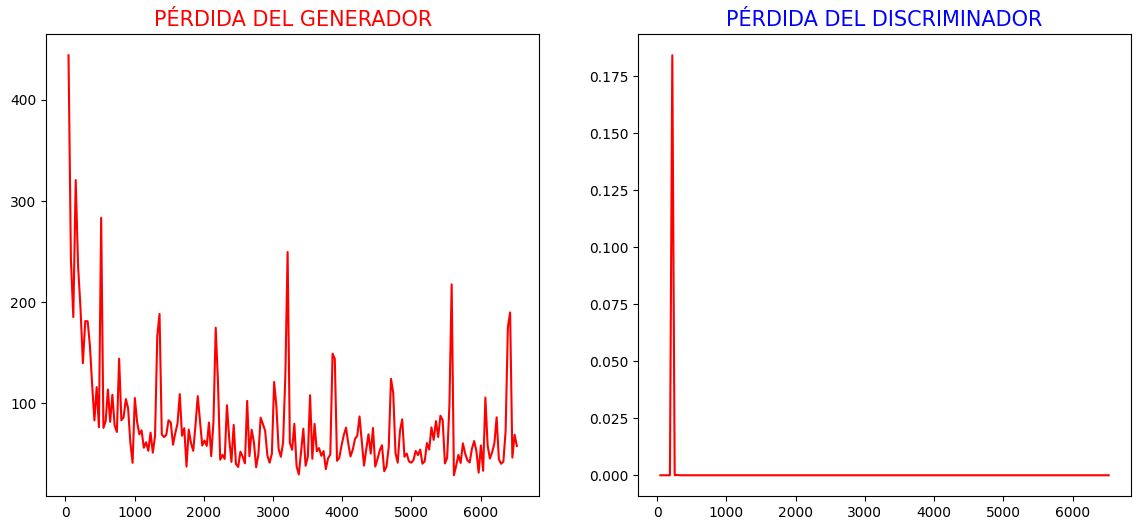

In [17]:
f, ax= plt.subplots(1,2, figsize=(14, 6))
losses = [gen_loss_array, disc_loss_array]
titles = ['PÉRDIDA DEL GENERADOR', 'PÉRDIDA DEL DISCRIMINADOR']
colors = ['r', 'b']

for c in range(2):
  ax[c].plot(time_array, losses[c], color='r')
  ax[c].set_title(titles[c], color=colors[c], fontsize=15)

Text(0.5, 1.0, 'RMSE')

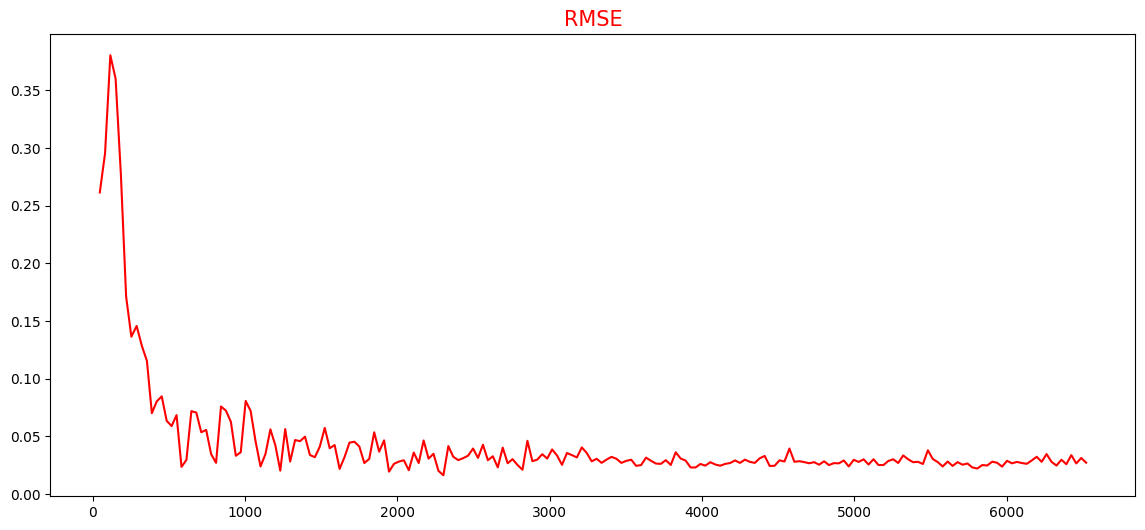

In [18]:
f, ax= plt.subplots(1,1, figsize=(14, 6))
metrics = rmse_error_array
titles = 'RMSE'
colors = 'r'

ax.plot(time_array, rmse_error_array, color='r')
ax.set_title(titles, color=colors, fontsize=15)

Guarda resultados en csv

In [19]:
data = {
    'Time': time_array,
    'RMSE Error': rmse_error_array,
    'Generator Loss': gen_loss_array,
    'Discriminator Loss': disc_loss_array,
    'HR Loss': hr_loss_array,
    'SR Loss': sr_loss_array
}

df = pd.DataFrame(data)
df.to_csv('metrics.csv', index=False)